In [1]:
%matplotlib inline
from __future__ import division


import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math

import tensorflow as tf

%load_ext autoreload
%autoreload 2

print(tf.__version__)
print(np.__version__)

np.random.seed(3)

1.1.0
1.12.1


In [2]:
# load in the test, training, and validation datasets
import processing_utils as putils

data, labels = putils.extract_np_arrays_from_ADNI()
data_dict, labels_dict = putils.partition_data(data, labels)


1069
(102400,)
(102400, 256, 256, 1)


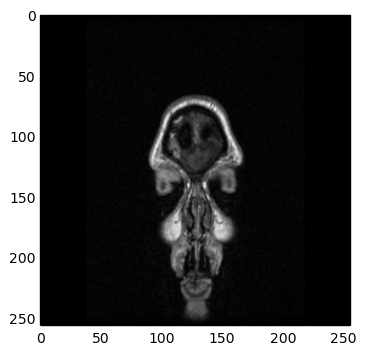

1
((1366, 256, 256, 1), (1366,))
((341, 256, 256, 1), (341,))
((341, 256, 256, 1), (341,))
('y_train', {0: 707, 1: 659})
('y_val', {0: 154, 1: 187})
('y_test', {0: 163, 1: 178})


In [3]:
# sanity checks

# print(labels)
# print(np.sum(data))

plt.imshow(data_dict['X_train'][202,: ,: , 0], cmap="gray")
plt.show()
print(labels_dict['y_train'][202])

# note: may want to subtract mean image

# check shape of each dataset
print(data_dict['X_train'].shape, labels_dict['y_train'].shape)
print(data_dict['X_val'].shape, labels_dict['y_val'].shape)
print(data_dict['X_test'].shape, labels_dict['y_test'].shape)

# check balance of flipped (1)/original (0) images in each dataset
unique, counts = np.unique(labels_dict['y_train'], return_counts=True)
print("y_train", dict(zip(unique, counts)))

unique, counts = np.unique(labels_dict['y_val'], return_counts=True)
print("y_val", dict(zip(unique, counts)))

unique, counts = np.unique(labels_dict['y_test'], return_counts=True)
print("y_test", dict(zip(unique, counts)))

In [3]:
# clear old variables
tf.reset_default_graph()

# setup input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 256, 256, 1]) # 32, 32, 3])
y = tf.placeholder(tf.int32, [None])
is_training = tf.placeholder(tf.bool)

def simple_model(X,y):
    # define our weights (e.g. init_two_layer_convnet)
    
    # setup variables # (W - F + 2P)/S + 1 = (256 - 8 + 0)/2 + 1 = 125 x 125 x 32
    Wconv1 = tf.get_variable("Wconv1", shape=[8, 8, 1, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])
    W1 = tf.get_variable("W1", shape=[500000, 2]) # shape=[43520, 2]) # [5408, 10])
    b1 = tf.get_variable("b1", shape=[2])

    # define our graph (e.g. two_layer_convnet)
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1, 2, 2, 1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    h1_flat = tf.reshape(h1, [-1,500000]) #5408])
    y_out = tf.matmul(h1_flat,W1) + b1
    return y_out


def cnn_mnist_model(X,y):

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
        inputs=X,
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
  
    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
  
    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    print(pool2)
    # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 64 * 64 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(inputs=dense, rate=0.4) #, training=mode) == learn.ModeKeys.TRAIN)
  
    # Logits Layer
    y_out = tf.layers.dense(inputs=dropout, units=2)
    return y_out

 
# y_out = simple_model(X,y)
y_out = cnn_mnist_model(X,y)

# define our loss
total_loss = tf.losses.hinge_loss(tf.one_hot(y,2),logits=y_out) # 10),logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# define our optimizer
optimizer = tf.train.AdamOptimizer(5e-4) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)

Tensor("max_pooling2d_2/MaxPool:0", shape=(?, 64, 64, 64), dtype=float32)


In [5]:
# Training the model on one epoch
# While we have defined a graph of operations above, in order to execute TensorFlow Graphs, by feeding them input data and 
#    computing the results, we first need to create a tf.Session object.
#    A session encapsulates the control and state of the TensorFlow runtime. For more information, see the TensorFlow Getting 
#    started guide.
# Optionally we can also specify a device context such as /cpu:0 or /gpu:0. 
# For documentation on this behavior see this TensorFlow guide

def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.cast(tf.argmax(predict,1), tf.int32), tf.cast(y, tf.int32))

    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%X_train.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[i:i+batch_size].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct



In [ ]:
with tf.Session() as sess:
    # for d in ['/gpu:0', '/gpu:1', '/gpu:2', '/gpu:3', '/gpu:4', '/gpu:5', '/gpu:6', '/gpu:7']:
    #     with tf.device(d):
    sess.run(tf.global_variables_initializer())
    print('Training')
    X_train = data_dict['X_train']
    y_train = labels_dict['y_train']
    X_val = data_dict['X_val']
    y_val = labels_dict['y_val']
    
    run_model(sess,y_out,mean_loss,X_train,y_train,5,64,100,train_step,False)
     
    print('Validation')
    run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Training
Iteration 0: with minibatch training loss = 9.45 and accuracy of 0.59
Iteration 100: with minibatch training loss = 0.989 and accuracy of 0.52
Iteration 200: with minibatch training loss = 0.948 and accuracy of 0.66
Iteration 300: with minibatch training loss = 0.98 and accuracy of 0.5
Iteration 400: with minibatch training loss = 1.03 and accuracy of 0.41
Iteration 500: with minibatch training loss = 1.01 and accuracy of 0.45
Iteration 600: with minibatch training loss = 1.01 and accuracy of 0.48
Iteration 700: with minibatch training loss = 0.984 and accuracy of 0.61
Iteration 800: with minibatch training loss = 1 and accuracy of 0.44
Iteration 900: with minibatch training loss = 0.994 and accuracy of 0.55
Iteration 1000: with minibatch training loss = 0.98 and accuracy of 0.62
Epoch 1, Overall loss = 5.81 and accuracy of 0.501
Iteration 1100: with minibatch training loss = 0.989 and accuracy of 0.53
Iteration 1200: with minibatch training loss = 1 and accuracy of 0.5
Iterat